# **Stock Market Prediction using Numerical and Textual Analysis**


Stock market prediction is the act of trying to determine the future value of a company stock or other financial instrument traded on an exchange. Numerical analysis involves using historical stock prices and other financial data to make predictions. Textual analysis involves analyzing news articles, social media posts, and other text data to extract insights that can be used to make predictions. By combining both numerical and textual analysis, we can build more accurate and robust models for predicting stock prices.

## Importing the Necessary Modules and Data
Before we begin our analysis, we need to import the necessary modules and data. We will be using the BSESN (Bombay Stock Exchange Sensitive Index) dataset to obtain historical stock prices and the News-Headlines dataset to obtain news articles for our textual analysis.


In [ ]:
# Have to use this version of scikit-learn, for mean_absolute_error 
# !pip install 'scikit-learn==0.24.0' 


In [2]:


import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_prices = pd.read_csv('/content/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/data/BSESN.csv')
df_prices

In [ ]:
cols = ['Date','Category','News']
df_news = pd.read_csv("/content/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/data/india-news-headlines.csv", names = cols)
df_news = df_news.dropna(axis = 0, how ='any') 
df_news

## Cleaning and Pre-processing the data:

In [ ]:
# Dropping 0 values, and the Category column as we don't require this for our analysis.
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)

In [ ]:
# Converting 'Date' columns from both our dataframes to type datetime
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices


In [ ]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

In [ ]:
# Group the dataframe by 'Date' and join the text in the 'News' column
df_news['News'] = df_news.groupby(['Date'])['News'].transform(lambda x: ' '.join(x))

# Drop duplicate rows from the dataframe
df_news = df_news.drop_duplicates()

# Reset the index of the dataframe
df_news.reset_index(inplace=True, drop=True)



In [14]:
# Initialize an empty list to store the cleaned headlines
c = []

# Loop through each headline in the 'News' column
for i in range(len(df_news['News'])):
    # Remove non-alphabetic characters from the headline
    news = re.sub('[^a-zA-Z]', ' ', df_news['News'][i])
    
    # Convert the headline to lowercase
    news = news.lower()
    
    # Split the headline into a list of words
    news = news.split()
    
    # Stem the words and remove stopwords
    news = [ps.stem(word) for word in news if word not in set(stopwords.words('english'))]
    
    # Join the words back into a single string
    news = ' '.join(news)
    
    # Append the cleaned headline to the list
    c.append(news)


In [ ]:
d=pd.Series(c)
d[23]

In [ ]:
df_news['News'] = pd.Series(c)
# df_news

## Calculating Subjectivity and Polarity scores using TextBlob module:

In [22]:
def getSubjectivity(text):
    """
    This function takes in a text string and returns its subjectivity score.
    Subjectivity is a measure of how subjective or objective the text is.
    A score of 0 means the text is completely objective, while a score of 1 means the text is completely subjective.
    """
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    """
    This function takes in a text string and returns its polarity score.
    Polarity is a measure of how positive or negative the text is.
    A score of -1 means the text is completely negative, while a score of 1 means the text is completely positive.
    A score of 0 means the text is neutral.
    """
    return TextBlob(text).sentiment.polarity


In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
# df_news

## Carrying out Sentimental Analysis on the News Headlines:

In [25]:
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Calculate the compound sentiment score for each headline
df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]

# Calculate the negative sentiment score for each headline
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]

# Calculate the neutral sentiment score for each headline
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]

# Calculate the positive sentiment score for each headline
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]


## Now for the exciting part!
We will use our findings from the Sentiment Analysis along with historical stock prices data to predict future stock prices using **Multivariate Time Series Forecasting**. This technique allows us to use multiple variables or features to forecast future values of a target variable. In our case, we will use the sentiment scores and historical stock prices as features to forecast future stock prices.



In [ ]:
# Merge the 'df_prices' and 'df_news' dataframes on the 'Date' column
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')

# Print the 'df_prices' dataframe
print(df_prices)

# Drop the 'Date' and 'News' columns from the merged dataframe
df_merge.drop(['Date', 'News'], axis=1, inplace=True)

# Print the column names of the merged dataframe
print(df_merge.columns)

# Print the number of rows in the merged dataframe
print(len(df_merge))

# Print the number of rows in the 'df_prices' dataframe
print(len(df_prices))

# Print the number of rows in the 'df_news' dataframe
print(len(df_news))


In [27]:
from pandas import DataFrame as df
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    This function takes in a time series dataset and converts it into a supervised learning dataset.
    The 'n_in' parameter specifies the number of lag observations to use as input features.
    The 'n_out' parameter specifies the number of future time steps to forecast.
    If 'dropnan' is set to True, rows with NaN values will be dropped from the resulting dataset.
    """
    # Determine the number of variables in the dataset
    n_vars = 1 if type(data) is list else data.shape[1]
    
    # Convert the input data into a DataFrame
    df1 = df(data)
    
    # Initialize lists to store the columns and column names
    cols, names = list(), list()
    
    # Create input features using lag observations
    for i in range(n_in, 0, -1):
        cols.append(df1.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Create output features using future observations
    for i in range(0, n_out):
        cols.append(df1.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Concatenate the columns into a single DataFrame
    agg = concat(cols, axis=1)
    
    # Set the column names
    agg.columns = names
    
    # Drop rows with NaN values if specified
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


In [ ]:
# Convert the values in the 'df_merge' dataframe to a NumPy array
values = df_merge.values

# Print the 'df_merge' dataframe
print(df_merge)

# Print the values array
print(values)

# Convert the values to float32
values = values.astype('float32')

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Convert the time series data into a supervised learning dataset
reframed = series_to_supervised(scaled, 1, 1)

# Drop columns that we don't want to predict
reframed.drop(reframed.columns[[12,13,14,16,17,18,19,20,21,22,23]], axis=1, inplace=True)

# Print the column names of the resulting dataset
print(reframed.columns)


### Building an LSTM (Long Short-Term Memory) Model to Predict Stock Prices
LSTM is a type of Recurrent Neural Network (RNN) that is capable of learning long-term dependencies in data. It is particularly useful for time series forecasting, where the goal is to predict future values based on past observations. In our case, we will use an LSTM model to predict future stock prices based on our historical data and sentiment analysis findings.


In [ ]:
# Convert the values in the 'reframed' dataframe to a NumPy array
values = reframed.values

# Print the shape of the values array
print(values.shape)

# Split the data into training and testing sets
n_train_hours = 90
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split the data into input and output features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape the input data into 3D arrays (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Print the shapes of the training and testing data
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


This code builds and trains an LSTM network to predict stock prices. The network consists of an LSTM layer with 50 units followed by a Dense layer with a single output unit. The model is trained using the mean absolute error (MAE) loss function and the Adam optimizer. The training and validation loss are plotted over time to visualize the model’s performance during training.

Epoch 1/50
2/2 - 5s - loss: 0.5045 - val_loss: 0.4408 - 5s/epoch - 2s/step
Epoch 2/50
2/2 - 0s - loss: 0.4723 - val_loss: 0.4103 - 38ms/epoch - 19ms/step
Epoch 3/50
2/2 - 0s - loss: 0.4405 - val_loss: 0.3797 - 52ms/epoch - 26ms/step
Epoch 4/50
2/2 - 0s - loss: 0.4089 - val_loss: 0.3489 - 38ms/epoch - 19ms/step
Epoch 5/50
2/2 - 0s - loss: 0.3772 - val_loss: 0.3179 - 51ms/epoch - 25ms/step
Epoch 6/50
2/2 - 0s - loss: 0.3458 - val_loss: 0.2866 - 37ms/epoch - 19ms/step
Epoch 7/50
2/2 - 0s - loss: 0.3157 - val_loss: 0.2550 - 40ms/epoch - 20ms/step
Epoch 8/50
2/2 - 0s - loss: 0.2858 - val_loss: 0.2229 - 37ms/epoch - 19ms/step
Epoch 9/50
2/2 - 0s - loss: 0.2553 - val_loss: 0.1903 - 37ms/epoch - 18ms/step
Epoch 10/50
2/2 - 0s - loss: 0.2249 - val_loss: 0.1572 - 37ms/epoch - 18ms/step
Epoch 11/50
2/2 - 0s - loss: 0.1976 - val_loss: 0.1244 - 35ms/epoch - 18ms/step
Epoch 12/50
2/2 - 0s - loss: 0.1752 - val_loss: 0.0929 - 37ms/epoch - 18ms/step
Epoch 13/50
2/2 - 0s - loss: 0.1592 - val_loss: 0.064

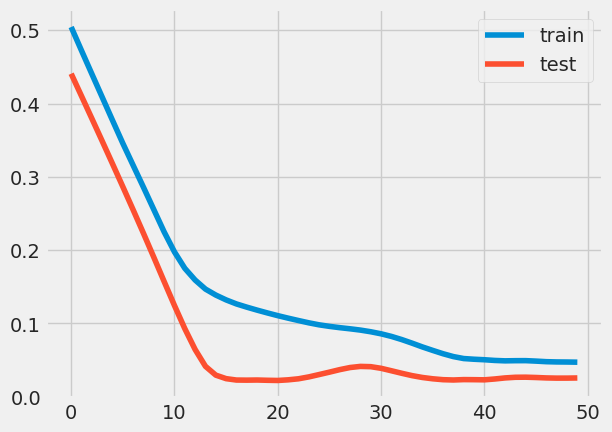

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Design the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit the network to the training data
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot the training and validation loss over time
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


### Testing the LSTM Model and Calculating RMSE (Root Mean Square Error)
After training our LSTM model, we will test its performance on the test data. We will use the trained model to make predictions on the test data and compare these predictions to the actual stock prices. To quantify the model's performance, we will calculate the Root Mean Square Error (RMSE) between the predicted and actual stock prices. RMSE is a commonly used metric for evaluating the performance of regression models.


In [31]:
# Make predictions on the test data
yhat = model.predict(test_X)

# Reshape the test data
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for the predicted values
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for the actual values
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate the RMSE between the predicted and actual values
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


1/1 [==============================] - 1s 589ms/step
Test RMSE: 494.947


We observe an RMSE of 494.947, which means that the predicted stock prices can be off by 494.947 units on average. Considering that the stock prices are in the order of tens of thousands (e.g., around 48k units), this is a pretty good RMSE. It shows that our hybrid model, which combines sentiment analysis with historical stock prices, works excellently in predicting future stock prices.
